**Mounting GDrive**

In [ ]:
from google.colab import drive

# This will prompt for authorization.
# mounting the drive to access the dataset
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Dataset**

In [ ]:
#tamil language corpus
tam_data=open("/content/gdrive/MyDrive/Dataset/training.ta-en.ta",encoding='utf-8').read()
tam_data=tam_data.split("\n")[:-1]
print("Sample:", tam_data[0])

Sample: அண்மைய வருடங்களில் பிரிட்பாப் வகை பிரபலமடைந்து ஒயாஸிஸ் ப்ளர் மற்றும் சூப்பர்கிராஸ் ஆகிய குழுக்கள் சர்வதேசப் புகழ் அடைந்தன.


In [ ]:
#english language corpus
eng_data=open("/content/gdrive/MyDrive/Dataset/training.ta-en.en",encoding='utf-8').read()
eng_data=eng_data.split("\n")[:-1]
print("Sample:", eng_data[0])

Sample: In recent years, britpop type became popular and the groups like Oasis, Blaire and SuperCross became world famous.


In [ ]:
#custom dataset
eng_tam_data=open("/content/gdrive/MyDrive/Dataset/training-eng-tam.txt").read()
eng_tam_data=eng_tam_data.split("\n")
print("Sample:", eng_tam_data[0])

Sample: I slept.	நான் தூங்கினேன்.	


**Data Preparation**

In [ ]:
#required library
import pandas as pd
import re

In [ ]:
en=[]
ta=[]
for i in eng_tam_data:
    var=i.split("\t")
    en.append(var[0])
    ta.append(var[1])


In [ ]:
# Dataset as Dataframe
df1=pd.DataFrame(list(zip(en,ta)),columns=["english","tamil"])

In [ ]:
df1.head()

,english,tamil
0,I slept.,நான் தூங்கினேன்.
1,Calm down.,அமைதியாக இருங்கள்
2,I'll walk.,நான் நடப்பேன்.
3,Who is he?,அவன் யார்?
4,Who knows?,யாருக்குத் தெரியும்?


In [ ]:
# English and Tamil Corpus as Dataframe
df2=pd.DataFrame(list(zip(eng_data,tam_data)),columns=["english","tamil"])

In [ ]:
df2.head()

,english,tamil
0,"In recent years, britpop type became popular a...",அண்மைய வருடங்களில் பிரிட்பாப் வகை பிரபலமடைந்து...
1,"recent years pritpop type has become famous, t...",அண்மைய வருடங்களில் பிரிட்பாப் வகை பிரபலமடைந்து...
2,In the recent year Britpop type was famous and...,அண்மைய வருடங்களில் பிரிட்பாப் வகை பிரபலமடைந்து...
3,"In recent years, Britpop type music was become...",அண்மைய வருடங்களில் பிரிட்பாப் வகை பிரபலமடைந்து...
4,duty honesty control,கடமை கண்ணியம் கட்டுபாடு


In [ ]:
df=pd.concat([df1,df2],ignore_index = True)

In [ ]:
df.shape

(35228, 2)

In [ ]:
def clean_text(text):
  #into lower case
  text=text.lower()                                           
  #remove the special characters
  text = re.sub(pattern="'",repl='',string=text)
  text = re.sub(pattern='[^a-z]+',repl=' ',string=text)                
  #remove extra spaces at end
  text=text.strip()                                           
  return text

In [ ]:
df["english"]=df["english"].map(clean_text)

In [ ]:
#slice the datapoints (have more datapoints based on the hardware)
df=df[:1000]

**Building the Vocabulary**

In [ ]:
#zipping the two language together
lang_data = list(zip(df["english"].values,df["tamil"].values)) 

In [ ]:
lang_data[3:10]

[('who is he', 'அவன் யார்?'),
 ('who knows', 'யாருக்குத் தெரியும்?'),
 ('she smiled', 'அவள் சிரித்தாள்'),
 ('talk to me', 'என்னிடம் பேசு'),
 ('who is she', 'அவள் யார்?'),
 ('go to sleep', 'போய் தூங்கு'),
 ('it may rain', 'மழை பெய்யலாம்')]

In [ ]:
#class to build vocabulary
#<blank>, SOS = Start of Sentence, EOS = End of Sentence
class Lang:
    def __init__(self, name):
        self.name = name
        #represent word with unique number
        self.word2index = {"<blank>":0, "SOS":1,"EOS":2}
        #no of words
        self.word2count = {}
        #to convert index to word
        self.index2word = {0:"<blank>", 1: "SOS", 2: "EOS"}
        #we have 3 items already (blank,sos,eos)
        self.n_words = 3  # Count SOS and EOS

    #function to add word to vocabulary
    def addSentence(self, sentence):
        #split sentence and add words to vocab
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        #we add the word, if word is not in vocab 
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            #increase the count of that word by 1
            self.word2count[word] += 1

In [ ]:
#initiate the class
eng_lang = Lang("english")
tam_lang = Lang("tamil")

In [ ]:
#building the vocab for both english and tamil language
for eng, tam in lang_data:
  eng_lang.addSentence(eng)
  tam_lang.addSentence(tam)

**Data Preprocessing**

In [ ]:
#function to tokenize the source language
def tokenize_eng(lang,sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [ ]:
#function to tokenize the target language
def tokenize_tam(lang,sentence):
    sent = "SOS" + " " + sentence + " " + "EOS"
    return [lang.word2index[word] for word in sent.split(' ')]

In [ ]:
#converting to array
import numpy as np
lang_data = np.array(lang_data) 

In [ ]:
lang_data

array([['i slept', 'நான் தூங்கினேன்.'],
       ['calm down', 'அமைதியாக இருங்கள்'],
       ['ill walk', 'நான் நடப்பேன்.'],
       ...,
       ['this ip address to very important to communicate the internet',
        'இந்த IP முகவரியானது வலைச் சேவையகத்தைத் தொடர்புகொள்ள மிகவும் அவசியமானதாகும்.'],
       ['the ip address and the root path in an internet protocol based network',
        'இந்த IP முகவரியானது வலைச் சேவையகத்தைத் தொடர்புகொள்ள மிகவும் அவசியமானதாகும்.'],
       ['ip address is important to internet for connecting purpose',
        'இந்த IP முகவரியானது வலைச் சேவையகத்தைத் தொடர்புகொள்ள மிகவும் அவசியமானதாகும்.']],
      dtype='<U479')

In [ ]:
#tokenize the source language
input_token=[tokenize_eng(eng_lang,i) for i in lang_data[:,0]]

#tokenize the target language
output_token=[tokenize_tam(tam_lang,i) for i in lang_data[:,1]]

In [ ]:
#checking the max length of input (source)
input_len = map(lambda x: len(x), input_token)
max_input_len = np.array(list(input_len)).max()
max_input_len

75

In [ ]:
#checking the max length of output (target)
output_len = map(lambda x: len(x), output_token)
max_output_len = np.array(list(output_len)).max()
max_output_len

44

In [ ]:
#assigning the max_length to 80
max_length=80

In [ ]:
#creating the empty array
input_tokenPad = np.zeros((len(input_token),max_length))
output_tokenPad = np.zeros((len(output_token),max_length))

In [ ]:
#source 
for i,v in enumerate(input_token):
    for j, token in enumerate(v):
        input_tokenPad[i,j] = token

In [ ]:
#target
for i,v in enumerate(output_token):
    for j, token in enumerate(v):
        output_tokenPad[i,j] = token

In [ ]:
input_tokenPad.shape

(1000, 80)

In [ ]:
output_tokenPad.shape

(1000, 80)

In [ ]:
#spliting the data
from sklearn.model_selection import train_test_split
train_eng, valid_eng,train_tam,valid_tam = train_test_split(input_tokenPad,output_tokenPad,test_size=0.2,shuffle=True)

In [ ]:
#converting to tensor
import torch
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(torch.from_numpy(train_eng).long(),torch.from_numpy(train_tam).long())
valid_data = TensorDataset(torch.from_numpy(valid_eng).long(),torch.from_numpy(valid_tam).long())

In [ ]:
#loads the data and serves the data in batches
batch_size = 32
train_loader= DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_loader =DataLoader(valid_data,shuffle=True,batch_size=batch_size)

**Lets bulid the model**

In [ ]:
#required libraries
import torch.nn as nn
import torch

Positional Encoding

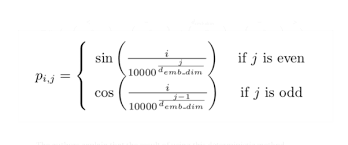

In [ ]:
#positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        #numerator
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        #denominator
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        #sin function for even index
        pe[:, 0::2] = torch.sin(position * div_term)
        #cos function for odd index
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        #multiply the input with positional encoding
        x = x * math.sqrt(self.d_model)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


Transformers

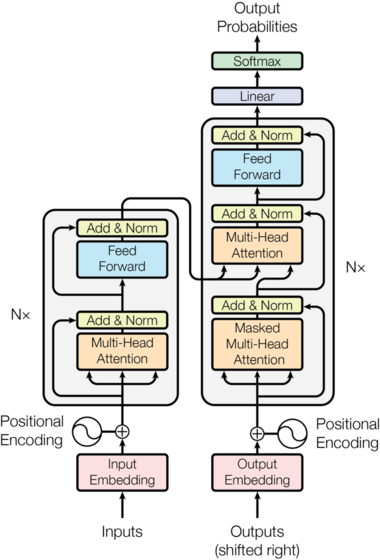

In [ ]:
#Transformers class
class MyTransformer(nn.Module):
    def __init__(self, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: str = "relu",source_vocab_length: int = 60000,target_vocab_length: int = 60000) -> None:
        super(MyTransformer, self).__init__()
        #embeddings
        self.source_embedding = nn.Embedding(source_vocab_length, d_model)
        self.target_embedding = nn.Embedding(target_vocab_length, d_model)
        
        #initialize positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        #initialize the encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        #layer normalization
        encoder_norm = nn.LayerNorm(d_model)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        
        #initialize the decoder layer
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        #layer normalization
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        
        #linear layer
        self.out = nn.Linear(512, target_vocab_length)
        self._reset_parameters()
        self.d_model = d_model
        self.nhead = nhead

    def forward(self, src, tgt, src_mask= None, tgt_mask = None,
                memory_mask = None, src_key_padding_mask= None,
                tgt_key_padding_mask = None, memory_key_padding_mask = None):
        if src.size(1) != tgt.size(1):
            raise RuntimeError("the batch number of src and tgt must be equal")
        #convert source language into embedding
        src = self.source_embedding(src)
        #add the positional encoding 
        src = self.pos_encoder(src)
        #pass it to the encoder
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        #convert target langauge into embedding
        tgt = self.target_embedding(tgt)
        #add the positional encoding 
        tgt = self.pos_encoder(tgt)
        #pass the target embedding and encoder representation to decoder
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        #output layer
        output = self.out(output)
        return output

    #Initiate parameters in the transformer model
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [ ]:
#no of words in source language
source_vocab_length=eng_lang.n_words

#no of words in target language
target_vocab_length=tam_lang.n_words

In [ ]:
#transformer model
import math
model = MyTransformer(source_vocab_length=source_vocab_length,target_vocab_length=target_vocab_length)

if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
#Adam optimiser
optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.9), eps=1e-9)


In [ ]:
import torch
def train(train_loader, valid_loader, model, optim, num_epochs): 
    #losses
    train_losses = []
    val_losses = []
    best_val_loss = 1000000
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss=0
        # set the model to train mode
        model.train()
        for i, batch in enumerate(train_loader): 
            if torch.cuda.is_available():
                #source
                src = batch[0].cuda() 
                #target
                trg =batch[1].cuda() 
            else:
                src = batch[0]
                trg =batch[1]

            trg_input = trg[:, :-1]
            #actual target
            targets = trg[:, 1:].contiguous().view(-1)
            size = trg_input.size(1)
            
            #no peek mask for the decoder   
            np_mask = torch.triu(torch.ones(size, size)==1).transpose(0,1)
            np_mask = np_mask.float().masked_fill(np_mask == 0, float('-inf')).masked_fill(np_mask == 1, float(0.0))
            np_mask = np_mask.cuda() if True else np_mask    
            
            #clearing the Gradients 
            optim.zero_grad()
            #predict the output
            preds = model(src.transpose(0,1), trg_input.transpose(0,1), tgt_mask = np_mask)
            #linear layer generates the logits vector whose size is our vocabulary size
            preds = preds.transpose(0,1).contiguous().view(-1, preds.size(-1))
            
            #calculate training loss
            loss = nn.functional.cross_entropy(preds,targets, ignore_index=0,reduction='sum')
            
            #back propagate
            loss.backward()
            optim.step()
            train_loss += loss.item()/batch_size        
        
        #set the model to eval mode
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                if torch.cuda.is_available():
                    #source
                    src = batch[0].cuda() 
                    #target
                    trg =batch[1].cuda() 
                else:
                    src = batch[0]
                    trg =batch[1]

                trg_input = trg[:, :-1]
                #actual target
                targets = trg[:, 1:].contiguous().view(-1)
                size = trg_input.size(1)
                
                #no peek mask for the decoder   
                np_mask = torch.triu(torch.ones(size, size)==1).transpose(0,1)
                np_mask = np_mask.float().masked_fill(np_mask == 0, float('-inf')).masked_fill(np_mask == 1, float(0.0))
                np_mask = np_mask.cuda() if True else np_mask    
                
                #predict the output
                preds = model(src.transpose(0,1), trg_input.transpose(0,1), tgt_mask = np_mask)
                #linear layer generates the logits vector whose size is our vocabulary size
                preds = preds.transpose(0,1).contiguous().view(-1, preds.size(-1))
                
                #calculate validation loss
                loss = nn.functional.cross_entropy(preds,targets, ignore_index=0,reduction='sum')
                val_loss += loss.item()/1
        #append the traning loss
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(valid_loader))         
        print("Epoch {0} Training loss: {1}".format(epoch+1,train_loss), "Val loss: {0}".format(val_loss))
        if val_loss < best_val_loss:
          torch.save(model, f'/content/gdrive/MyDrive/Models/{epoch+1}.pth')
          best_val_loss = val_loss
    return train_losses,val_losses

In [ ]:
num_epochs=40
train_losses,val_losses = train(train_loader,valid_loader ,model, optim, num_epochs)

Epoch 1 Training loss: 5.334908656775951 Val loss: 2300.5811080932617
Epoch 2 Training loss: 4.904294945299625 Val loss: 2456.8512268066406
Epoch 3 Training loss: 4.81286583840847 Val loss: 2432.479839324951
Epoch 4 Training loss: 4.93040069937706 Val loss: 2433.393264770508
Epoch 5 Training loss: 4.563778921961784 Val loss: 2436.084701538086
Epoch 6 Training loss: 3.4743727222085 Val loss: 2441.7644233703613
Epoch 7 Training loss: 3.560394611209631 Val loss: 2464.388847351074
Epoch 8 Training loss: 3.479350760579109 Val loss: 2415.4876098632812
Epoch 9 Training loss: 2.6654453352093697 Val loss: 2437.2326889038086
Epoch 10 Training loss: 2.6707431487739086 Val loss: 2437.287399291992
Epoch 11 Training loss: 2.51159305870533 Val loss: 2480.697067260742


KeyboardInterrupt: ignored

In [ ]:
#to save the model
torch.save(model, "transformer_model_eng2tamil.h5")

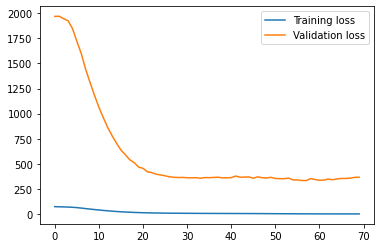

In [ ]:
#plotting the losses, loss is decreasing for each epoch
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
# Inference
model = torch.load('/content/gdrive/MyDrive/Models/eng2tamil.pth')

**Prediction**

In [ ]:
import torch
from torch.autograd import Variable
import math

def eng_to_tam_converter(model,sentence):
    #set the model to eval mode
    model.eval()
    #split the input sentence
    sentence = sentence.split()
    translated_sentence=""
    #converting the word to index
    indexed = []
    for tok in sentence:
        try:
            if eng_lang.word2index[tok] != 0 :
                indexed.append(eng_lang.word2index[tok])
            else:
                indexed.append(0)
        except:
            print(tok,"is not in vocab")
    
    #convert the indexes into tensor
    sentence = Variable(torch.LongTensor([indexed])).cuda()  if True else Variable(torch.LongTensor([indexed]))
    
    #first token to the decoder
    trg_init_tok =eng_lang.word2index["SOS"]
    trg = torch.LongTensor([[trg_init_tok]]).cuda() if True else torch.LongTensor([[trg_init_tok]])
    translated_sentence = ""
    print("Converting...")

    #max embedding size
    maxlen = 150
    for i in range(maxlen):
        #predict the target word
        pred = model(sentence.transpose(0,1), trg)
        #convert the predicted index to word
        add_word = tam_lang.index2word[pred.argmax(dim=2)[-1].item()] 
        print(add_word)
        #end when we got EOS (end of sentence)
        if add_word=="EOS":
            break
        #update the translated_sentence
        translated_sentence+=" "+add_word
        #pass the predict word to the decoder as input
        trg = torch.cat((trg,torch.LongTensor([[pred.argmax(dim=2)[-1]]]).cuda()))
    print("\nConverted sentence:-")
    return translated_sentence

*Example 1:*

In [ ]:
sentence = "I want to become an astronaut in the future"
print(eng_to_tam_converter(model,clean_text(sentence)))

astronaut is not in vocab
Converting...
நான்
எதிர்
காலத்தில்
ஒரு
விமானியாக
விரும்புகிறேன்
EOS

Converted sentence:-
 நான் எதிர் காலத்தில் ஒரு விமானியாக விரும்புகிறேன்


*Example 2:*

In [ ]:
sentence = "I'm kind of happy" 
print(eng_to_tam_converter(model,clean_text(sentence)))

Converting...
நான்
ஒரு
விதமான
மகிழ்ச்சியிலிருக்கிறேன்
EOS

Converted sentence:-
 நான் ஒரு விதமான மகிழ்ச்சியிலிருக்கிறேன்


In [ ]:
sentence = "She gave him a book" 
print(eng_to_tam_converter(model,clean_text(sentence)))

Converting...
அவள்
அவனுக்கு
ஒரு
புத்தகத்தைக்
கொடுத்தாள்
EOS

Converted sentence:-
 அவள் அவனுக்கு ஒரு புத்தகத்தைக் கொடுத்தாள்
